# MLP applied to quantum metrology

In this notebook we see how the the inefficiency of the detector affects the performance of the network

In [10]:
"Code imports"
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import loadtxt
from numpy import savetxt
from scipy.sparse.linalg import expm, expm_multiply
from scipy import sparse

In [3]:
"Now we import and preprocess the registers"
"We import the registers"
n_Delta=100 
Delta_vec=np.linspace(1,5,n_Delta)

Delta_class=list(range(n_Delta))


diccionario_clases=dict(zip(Delta_vec,Delta_class))




out_name = "C:/Users/Manuel/Desktop/universidad/beca_gefes_2021/proyecto/archivos_clicks/n_Delta_100_n_clicks_100/clicks_deltas_Omega_3.csv"

Deltas_and_clicks=loadtxt(out_name,delimiter=",")


y_full=Deltas_and_clicks[:,0] 
y_full_class=np.vectorize(diccionario_clases.get)(y_full)
X_full=Deltas_and_clicks[:,1:] 

"We are only interested in the time difference between photons"
X_full[:,1:]=X_full[:,1:]-X_full[:,:-1]



ratio=0.8
limit=int(ratio*len(y_full))
y_train,y_valid=y_full_class[:limit],y_full_class[limit:]

"We reescale the photon times so that the inputs are between 0 and 1 as it is in that range where we have"
"the most expresivity of the activation functions"
maxX=np.amax(X_full)
X_train,X_valid=X_full[:limit,:]/maxX,X_full[limit:,:]/maxX



We define 2 functions: 
register_composer which reorganizes the dataset so that we can have longer registers (at the cost of less registers).
not_perfect_detector which implements the fact that our detector can only detect a photon with limited efficiency ($\eta$)

In [11]:
def register_composer(register_array, n_Delta, n_compose):
    """ n_Delta is the number of values of delta that we simulate
    n_compose is how many registers are a new register, since what we store
    are time differences between photons, we can just compose them.
    """
    register_array_len = register_array.shape[0]
    n_chunks = register_array_len // n_Delta
    n_blocks = n_chunks // n_compose 
    reg_len = register_array.shape[1]
    new_register_array = np.zeros([n_blocks*n_Delta, reg_len * n_compose])
    for ii in range(n_blocks):
        for jj in range(n_compose):
            reg_block =register_array[
                                   (ii*n_compose+jj)*n_Delta : (ii*n_compose+jj+1)*n_Delta,:reg_len]
            new_register_array[ii*n_Delta : (ii+1)*n_Delta, 
                               reg_len*jj: reg_len*(jj+1)]= reg_block
    
    return new_register_array



def not_perfect_detector(register_array, efficiency):
    """efficiency is the probability of a click being detected"""
    
    n_registers = register_array.shape[0]
    register_len = register_array.shape[1]
    minimum_size = register_len
    register_list = list()  
    # We will store the transformed registers here for now
    for ii in range(n_registers):
        register = register_array[ii,:] 
        trans_register = list()
        acc_time = 0 # accumulated time
        for jj in range(register_len):
            random = np.random.rand()
            if random > efficiency:
                acc_time = acc_time + register[jj]
            else:
                trans_register.append(register[jj] + acc_time)
                acc_time = 0
        
        #We track the size of the shortest array
        register_list.append(trans_register)
        minimum_size = min(minimum_size, len(trans_register))
        """ Now we transform everything into a numpy array, and
        for that we will slice to the minimum size so that all our registers
        are the same length"""
        
    register_array = np.zeros([n_registers, minimum_size])
    for ii in range(n_registers):
        register = np.asarray(register_list[ii])
        register_array[ii,:] = register[:minimum_size]
    print("Minimum size: " + str(minimum_size))
    return register_array


In [12]:
"""Now we are going to compose registers so that each of them 
are 200 clicks long and then apply the efficiency method.

We will compare a neural network trained with perfect registers, one with 
registers that have non unit efficiency and the bayesian method. 
All of them will try predict the delta of registers with non unit efficiency.
"""    
    
X_full_composed = register_composer(X_full, 100, 2)
X_full_flawed = not_perfect_detector(X_full_composed, efficiency = 0.8)
X_full_composed = X_full_composed[:, :100]
X_full_flawed = X_full_flawed[:,:100]
y_full_composed = y_full_class[:X_full_composed.shape[0]]
"y_full_composed is the same as y_full_flawed"   

Minimum size: 133


'y_full_composed is the same as y_full_flawed'

In [13]:
"We are also going to import the function necessary for the probability distribution computation though the"
"formal quantum method"

def logS_t(Omega,Delta,t):
    #Te calcula la matriz que debes exponenciar
    #para tener S(t), introduces la Omega y el tiempo como argumento
    aux=np.matrix(np.zeros((4,4)),dtype=complex)
    aux[0,1]=1j*t*Omega
    aux[0,2]=-1j*t*Omega
    aux[1,0]=1j*t*Omega
    aux[1,1]=t*(-1/2+1j*Delta)
    aux[1,3]=-1j*t*Omega
    aux[2,0]=-1j*t*Omega
    aux[2,2]=t*(-1/2-1j*Delta)
    aux[2,3]=1j*t*Omega
    aux[3,1]=-1j*t*Omega
    aux[3,2]=1j*t*Omega
    aux[3,3]=-1*t
    
    return aux


def trace_liouv(density_matrix):
    #aquí defino una función auxiliar que me 
    #saca la traza de la matriz densidad cuando está dada en forma vector
    return density_matrix[0]+density_matrix[3]


def delta_prob_distribution(clicks_processed, Delta_vec, Omega):
    J=np.matrix(np.zeros((4,4)))
    J[0,3]=1
    J=sparse.csr_matrix(J)
    n_Delta=len(Delta_vec)
    
    
    # Definimos las matrices densidad en el instante inicial
    ro_0=np.asarray([1,0,0,0],dtype=complex)
    
    prob_matrix=np.zeros(n_Delta)
    
    for j in range(n_Delta):
        Delta=Delta_vec[j]
        ro=ro_0
        for i in range(len(clicks_processed)):
            t=clicks_processed[i]
            ro=expm(logS_t(Omega,Delta,t)).dot(ro)
            ro=J.dot(ro)
            #print(trace_liouv(ro_list[j]).real)
        prob_matrix[j]=trace_liouv(ro).real
        #print("j= "+str(j))
    prob_matrix_normalised=prob_matrix/(np.sum(prob_matrix[:]))
    
    return prob_matrix_normalised

Text(0, 0.5, 'Probability')

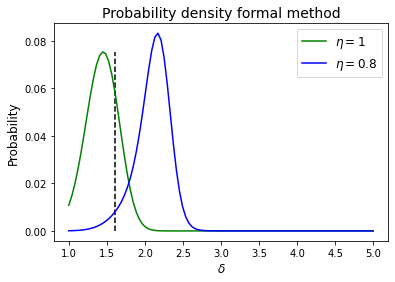

In [14]:
loc = 415
prob_density_bayes = delta_prob_distribution(X_full_composed[loc], 
                                             Delta_vec, Omega = 3)
plt.vlines(y_full[loc], np.amin(prob_density_bayes), np.amax(prob_density_bayes), 
           colors = "k",  linestyles="dashed")
prob_density_bayes_flawed = delta_prob_distribution(X_full_flawed[loc], 
                                             Delta_vec, Omega = 3)
plt.plot(Delta_vec, prob_density_bayes, "g-")
plt.plot(Delta_vec, prob_density_bayes_flawed, "b-")
plt.legend(["$\eta=1$", "$\eta=0.8$"], fontsize=12)
plt.title("Probability density formal method", fontsize = 14)
plt.xlabel("$\delta$", fontsize=12)
plt.ylabel("Probability", fontsize=12)

What we see is that a non unit $\eta$ means longer photon times and that is typically associated with bigger values
of $\delta$, that's why we see that the distribution has moved.

We will see what happens when we train a MLP with registers of $\eta = 1$ and $\eta = 0.8$ and then we evaluate it in
$\eta = 0.8$ registers.

In [15]:
"We are going to train two MLP, one with perfect registers and one with "
"flawed registers, and then evaluate for flawed registers"

ratio=0.8
limit=int(ratio*len(y_full_composed))
y_train_composed , y_valid_composed = y_full_composed[:limit],y_full_composed[limit:]
X_train_composed , X_valid_composed = X_full_composed[:limit,:], X_full_composed[limit:,:]
X_train_flawed , X_valid_flawed = X_full_flawed[:limit,:], X_full_flawed[limit:,:]


nn_flawed=keras.models.Sequential([
   # keras.layers.Dense(10,activation="relu",input_shape=X_train.shape[1:]),
    # El .shape[1:] es porque el primer indice nos dice el numero de tensores
    # que disponemos de datos y cada tensor es lo que le llega realmente a la
    # red como input. Por eso, determinamos el input de la primera capa así
    keras.layers.Dense(300,activation="relu"),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(n_Delta,activation="softmax")

    # El activador es softmax para que salga una distribucion normalizada


    ])
es = EarlyStopping(monitor='val_accuracy', 
                       mode='max', verbose=1, patience=10, min_delta=0.01, 
                       restore_best_weights=True)
nn_flawed.compile(loss="sparse_categorical_crossentropy", 
                                optimizer="adam",metrics=["accuracy"])
nn_flawed.fit( X_train_flawed, y_train_composed, epochs = 50,
                            validation_data = (X_valid_flawed, y_valid_composed), 
                            callbacks = [es])




nn_composed=keras.models.Sequential([
   # keras.layers.Dense(10,activation="relu",input_shape=X_train.shape[1:]),
    # El .shape[1:] es porque el primer indice nos dice el numero de tensores
    # que disponemos de datos y cada tensor es lo que le llega realmente a la
    # red como input. Por eso, determinamos el input de la primera capa así
    keras.layers.Dense(300,activation="relu"),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(n_Delta,activation="softmax")

    # El activador es softmax para que salga una distribucion normalizada


    ])
es = EarlyStopping(monitor='val_accuracy', 
                       mode='max', verbose=1, patience=10, min_delta=0.01, 
                       restore_best_weights=True)
nn_composed.compile(loss="sparse_categorical_crossentropy", 
                                optimizer="adam",metrics=["accuracy"])
nn_composed.fit( X_train_composed, y_train_composed, epochs = 50,
                            validation_data = (X_valid_composed, y_valid_composed), 
                            callbacks = [es])

Epoch 1/50
1250/1250 [==============================] - 5s 4ms/step - loss: 4.5280 - accuracy: 0.0129 - val_loss: 4.3508 - val_accuracy: 0.0238
Epoch 2/50
1250/1250 [==============================] - 5s 4ms/step - loss: 4.1441 - accuracy: 0.0249 - val_loss: 3.9682 - val_accuracy: 0.0335
Epoch 3/50
1250/1250 [==============================] - 4s 3ms/step - loss: 3.9083 - accuracy: 0.0326 - val_loss: 3.9068 - val_accuracy: 0.0301
Epoch 4/50
1250/1250 [==============================] - 4s 3ms/step - loss: 3.8467 - accuracy: 0.0354 - val_loss: 3.8439 - val_accuracy: 0.0325
Epoch 5/50
1250/1250 [==============================] - 4s 3ms/step - loss: 3.8149 - accuracy: 0.0356 - val_loss: 3.8222 - val_accuracy: 0.0360
Epoch 6/50
1250/1250 [==============================] - 4s 3ms/step - loss: 3.7900 - accuracy: 0.0375 - val_loss: 3.8184 - val_accuracy: 0.0348
Epoch 7/50
1250/1250 [==============================] - 4s 3ms/step - loss: 3.7704 - accuracy: 0.0373 - val_loss: 3.8402 - val_accuracy:

Text(0, 0.5, 'Probability')

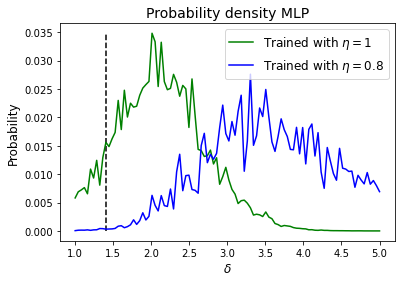

In [16]:
loc = 210
y_pred_nn_composed = nn_composed.predict(X_valid_flawed[loc:loc+1])[0]
y_pred_nn_flawed = nn_flawed.predict(X_valid_flawed[loc:loc+1])[0]


plt.vlines(Delta_vec[y_valid_composed[loc]], np.amin(y_pred_nn_flawed), np.amax(y_pred_nn_flawed), 
           colors = "k",  linestyles="dashed")

plt.plot(Delta_vec, y_pred_nn_flawed, "g-")
plt.plot(Delta_vec, y_pred_nn_composed, "b-")
plt.legend(["Trained with $\eta=1$", "Trained with $\eta=0.8$"], fontsize=12)
plt.title("Probability density MLP", fontsize = 14)
plt.xlabel("$\delta$", fontsize=12)
plt.ylabel("Probability", fontsize=12)

In [ ]:
def interval_plot(model, X_valid, Delta_vec, title: str): 
    
    # Aquí ponemos el código del benchmark
    y_pred=model.predict(X_valid)
    
    n_blocks=int(np.floor(y_pred.shape[0]/100)) 
    # numero de bloques, siendo un bloque las predicciones para todo el dominio
    # de deltas
    
    
    
    y_pred_product=y_pred[:100,:]**(1/n_blocks) # Los productos
    
    
    
    for i in range(n_blocks-1):
        y_pred_product=y_pred_product*y_pred[(i+1)*100:(i+1)*100+100,:]**(1/n_blocks)
    
    for ii in range(y_pred_product.shape[0]):
        y_pred_product[ii,:]=y_pred_product[ii,:]/(np.sum(y_pred_product[ii,:]))
    
    # Ahora sacamos las lineas de la predicción y del intervalo de confianza
    Delta_upper=np.zeros(100)
    Delta_mid=np.zeros(100)
    Delta_lower=np.zeros(100)
    
    for i in range(100):
        arr=y_pred_product[i,:]
        max_h=np.amax(arr)
        pos_arr=np.where(arr>max_h/2)
        Delta_lower[i]=Delta_vec[pos_arr[0][0]]# Tengo que poner un [0] delante para indicar que quiero sacar un elemento de un
        Delta_upper[i]=Delta_vec[pos_arr[0][-1]] # array. Personalmente, npi del sentido
    
    for ii in range(100):
        Delta_mid[ii]=np.sum(y_pred_product[ii,:]*Delta_vec[:])
    
    plt.figure()
    plt.plot(Delta_vec,Delta_vec,"k--")
    plt.plot(Delta_vec,Delta_mid,"b-")
    plt.fill_between(Delta_vec,Delta_upper,Delta_lower,alpha=0.3,color="red")
    
    plt.legend(["Simulated $\delta$","Network prediction","Confidence interval"], 
               fontsize = 12)
    plt.xlabel("$\delta$",fontsize = 12)
    plt.ylabel("Prediction", fontsize = 12)
    plt.title(title, fontsize = 14)
    plt.show
    
def interval_plot_lines(model, X_valid, Delta_vec): 
    
    # Aquí ponemos el código del benchmark
    y_pred=model.predict(X_valid)
    
    n_blocks=int(np.floor(y_pred.shape[0]/100)) 
    # numero de bloques, siendo un bloque las predicciones para todo el dominio
    # de deltas
    
    
    
    y_pred_product=y_pred[:100,:]**(1/n_blocks) # Los productos
    
    
    
    for i in range(n_blocks-1):
        y_pred_product=y_pred_product*y_pred[(i+1)*100:(i+1)*100+100,:]**(1/n_blocks)
    
    for ii in range(y_pred_product.shape[0]):
        y_pred_product[ii,:]=y_pred_product[ii,:]/(np.sum(y_pred_product[ii,:]))
    
    # Ahora sacamos las lineas de la predicción y del intervalo de confianza
    Delta_upper=np.zeros(100)
    Delta_mid=np.zeros(100)
    Delta_lower=np.zeros(100)
    
    for i in range(100):
        arr=y_pred_product[i,:]
        max_h=np.amax(arr)
        pos_arr=np.where(arr>max_h/2)
        Delta_lower[i]=Delta_vec[pos_arr[0][0]]# Tengo que poner un [0] delante para indicar que quiero sacar un elemento de un
        Delta_upper[i]=Delta_vec[pos_arr[0][-1]] # array. Personalmente, npi del sentido
    
    for ii in range(100):
        Delta_mid[ii]=np.sum(y_pred_product[ii,:]*Delta_vec[:])
        
    return Delta_upper, Delta_mid, Delta_lower

We can see the same effect than in the formal quantum method.
Now in the following plots we see the performance of a neural network trained with different efficiency at
evaluating registers that come from a detector with a 80% efficiency

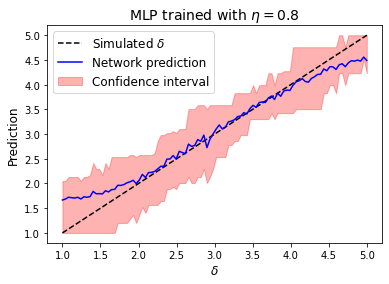

In [17]:
interval_plot(nn_flawed, X_valid_flawed, Delta_vec, 
              "MLP trained with $\eta = 0.8$")

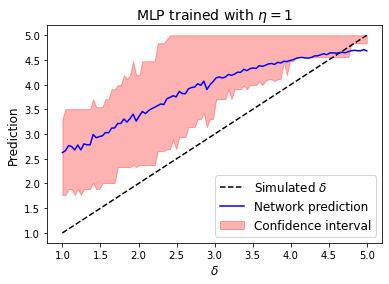

In [18]:
interval_plot(nn_composed, X_valid_flawed, Delta_vec, 
              "MLP trained with $\eta = 1$")

We can see that when we train with registers with the same efficiency as the future detector the performance
increases drastically

<function matplotlib.pyplot.show(close=None, block=None)>

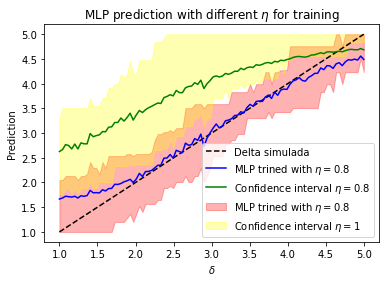

In [19]:
"Combining both plots"

Delta_upper_flawed, Delta_mid_flawed, Delta_lower_flawed = interval_plot_lines(
    nn_flawed, X_valid_flawed, Delta_vec)

Delta_upper_composed, Delta_mid_composed, Delta_lower_composed = interval_plot_lines(
    nn_composed, X_valid_flawed, Delta_vec)


plt.plot(Delta_vec,Delta_vec,"k--")
plt.plot(Delta_vec,Delta_mid_flawed,"b-")

plt.fill_between(Delta_vec,Delta_upper_flawed,Delta_lower_flawed,alpha=0.3,color="red")

plt.plot(Delta_vec,Delta_mid_composed,"g-")

plt.fill_between(Delta_vec,Delta_upper_composed,Delta_lower_composed,alpha=0.3,color="yellow")

plt.legend(["Delta simulada","MLP trined with $\eta = 0.8$",
            "Confidence interval $\eta = 0.8$", "MLP trined with $\eta = 0.8$", 
            "Confidence interval $\eta = 1$"])
plt.xlabel("$\delta$")
plt.ylabel("Prediction")
plt.title("MLP prediction with different $\eta$ for training")
plt.show